Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
Nhập lựa chọn (1-2): 2
=== Bắt đầu thử nghiệm ===

=== Phân tích mạng ===
Số lượng nút: 77
Số lượng cạnh: 254
Hệ số clustering trung bình: 0.573


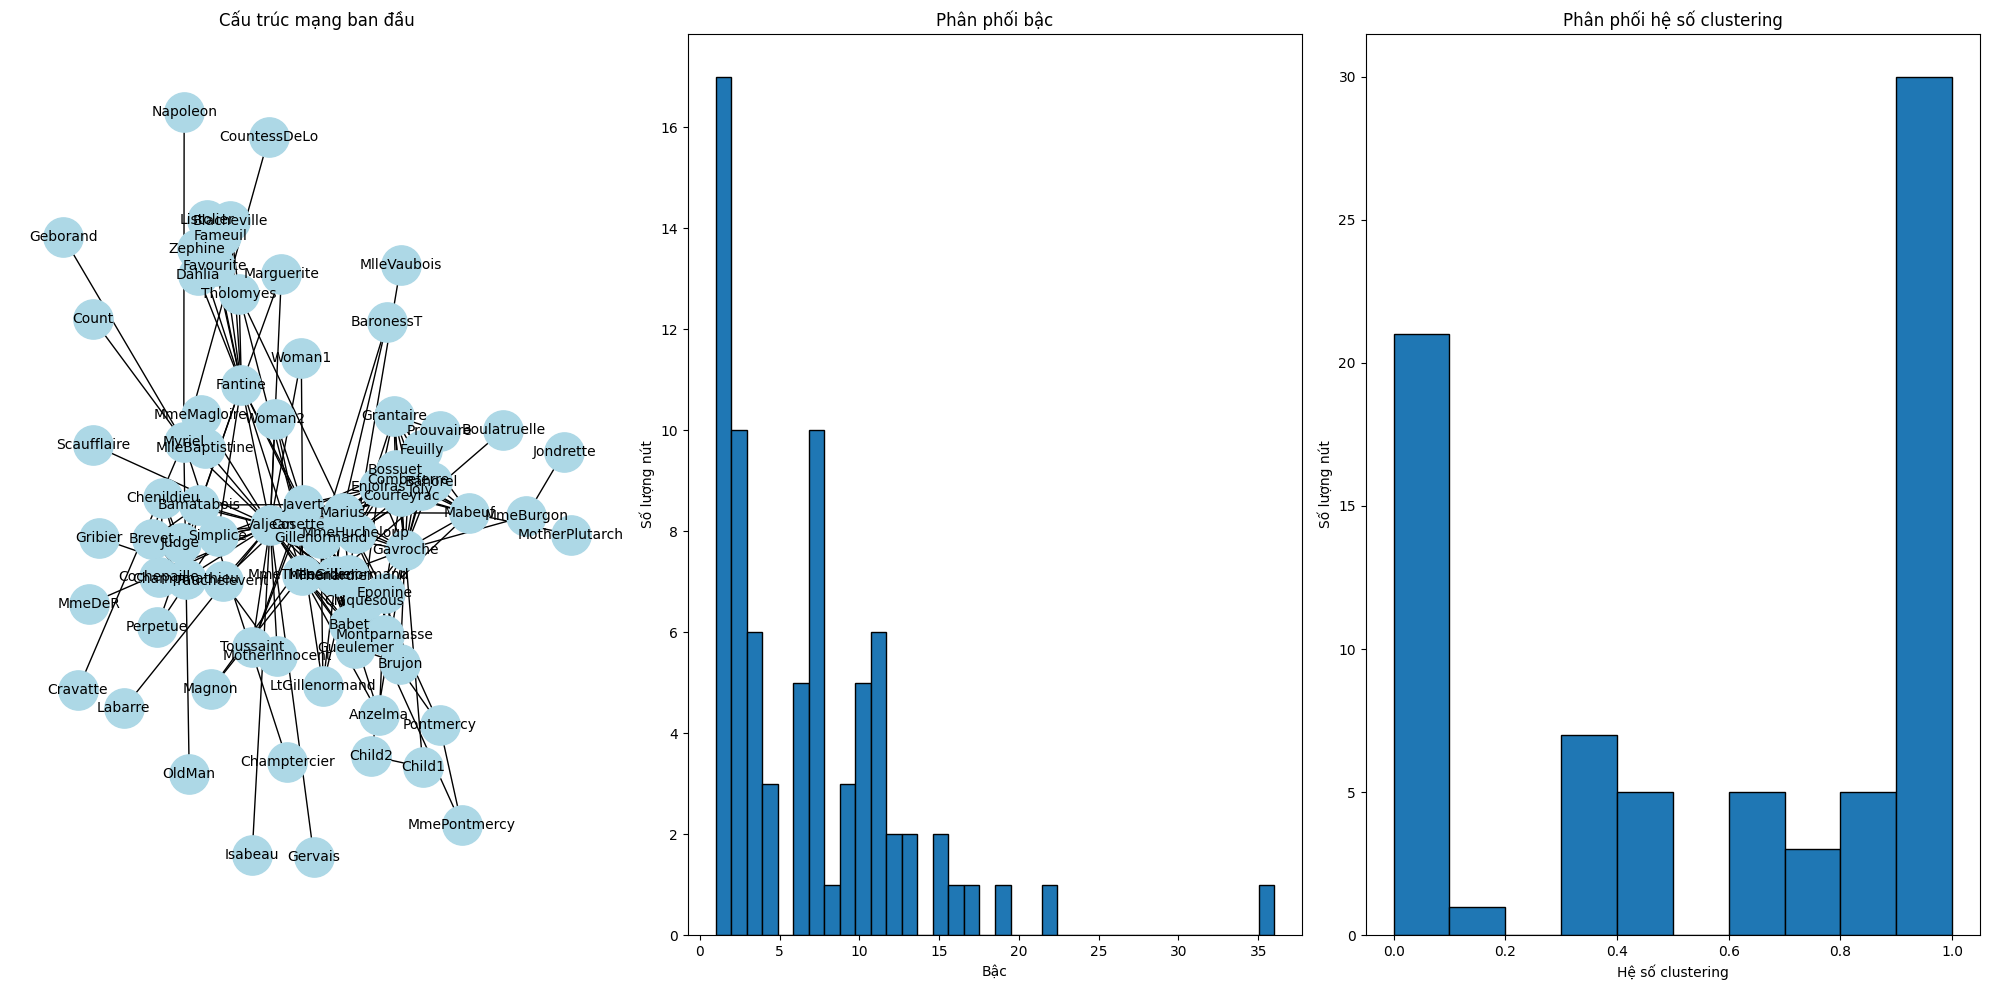


=== Thông tin về tập dữ liệu ===
Tổng số cạnh ban đầu: 254
Số cạnh huấn luyện: 203
Số cạnh kiểm tra (cạnh sẽ xuất hiện): 51
Số cặp nút kiểm tra không có cạnh: 51


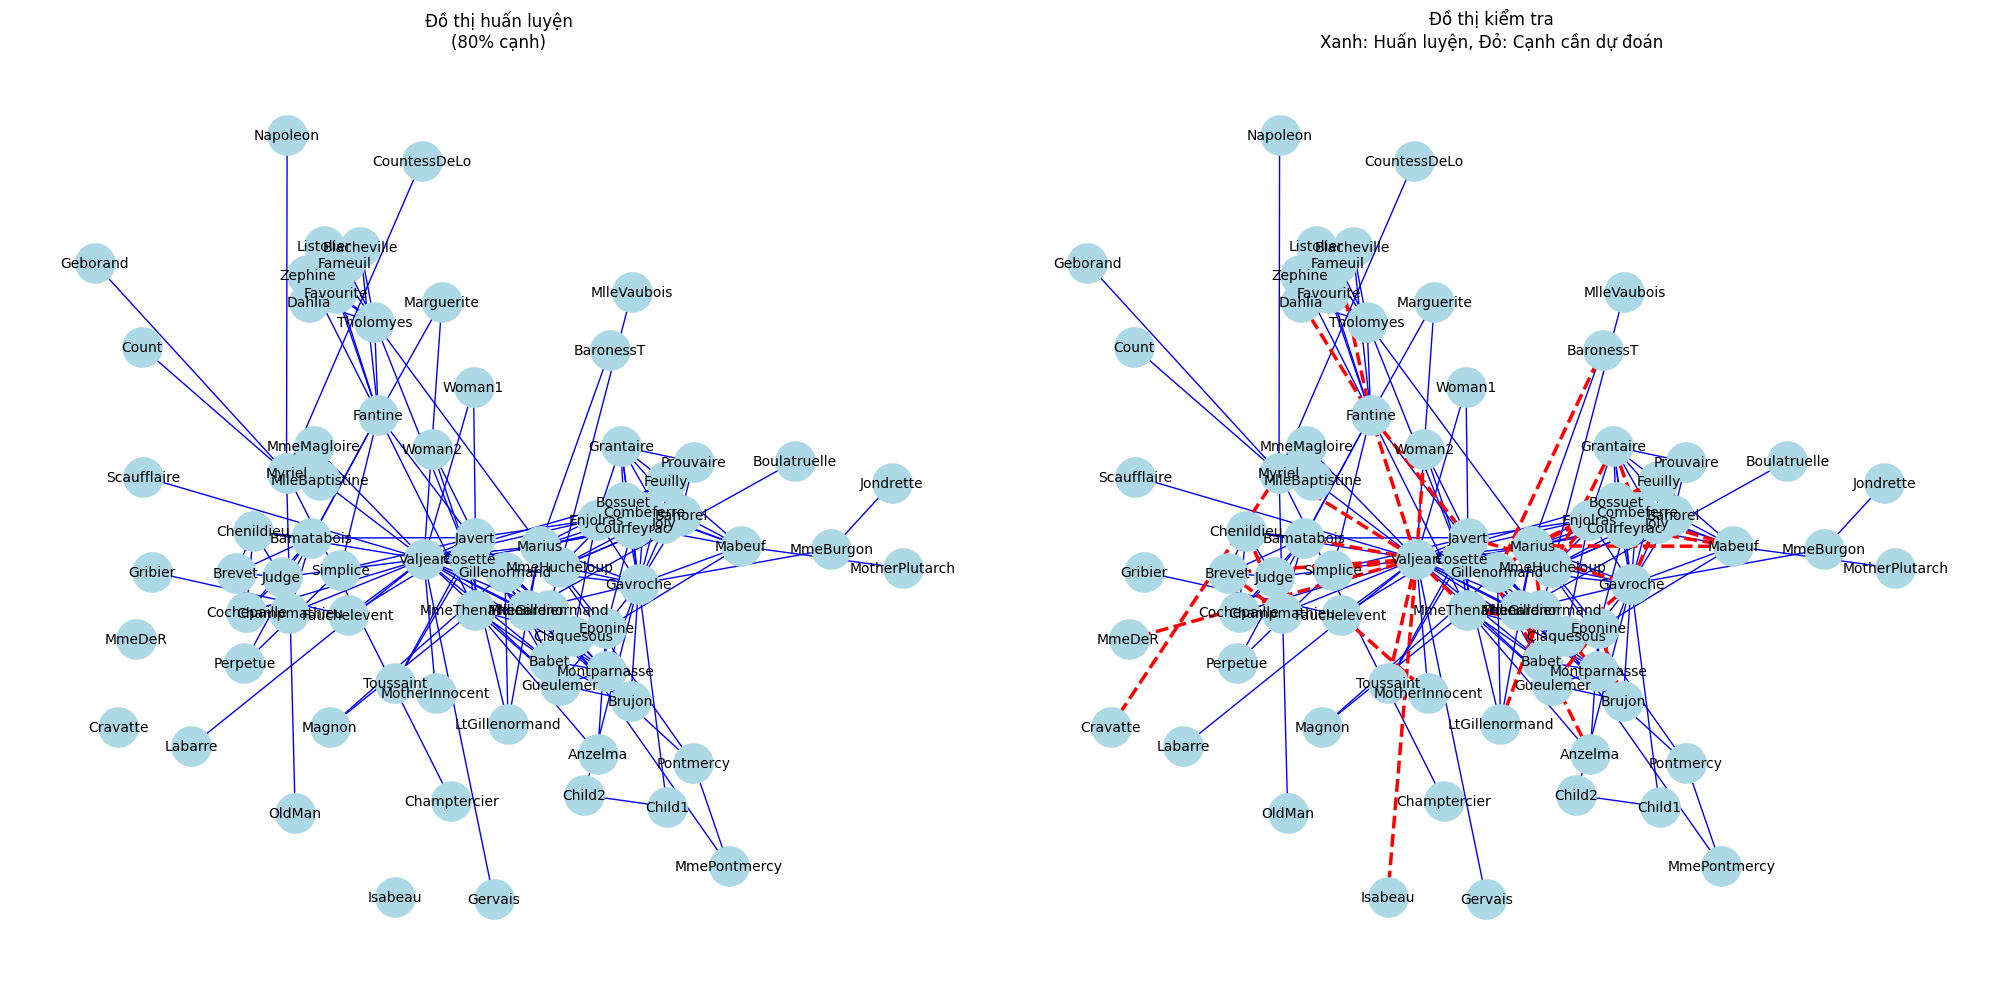

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

class LinkPredictionExperiment:
    def __init__(self, data_source='karate'):
        """
        Khởi tạo với lựa chọn dataset.

        Parameters:
            data_source (str): Tên dataset ('karate', 'les')
        """
        if data_source == 'karate':
            self.network = nx.karate_club_graph()
        elif data_source == 'les':
            self.network = nx.les_miserables_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def basic_network_analysis(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số lượng nút: {self.network.number_of_nodes()}")
        print(f"Số lượng cạnh: {self.network.number_of_edges()}")
        print(f"Hệ số clustering trung bình: {nx.average_clustering(self.network):.3f}")

        plt.figure(figsize=(20, 10))

        # Vẽ cấu trúc mạng ban đầu
        plt.subplot(131)
        layout = nx.spring_layout(self.network, seed=42, k=0.5)
        nx.draw(self.network, layout, with_labels=True, node_color='lightblue',
                node_size=800, font_size=10)
        plt.title("Cấu trúc mạng ban đầu")

        # Vẽ phân phối bậc
        plt.subplot(132)
        degrees = [d for _, d in self.network.degree()]
        plt.hist(degrees, bins=max(degrees)-min(degrees)+1, edgecolor='black')
        plt.title("Phân phối bậc")
        plt.xlabel("Bậc")
        plt.ylabel("Số lượng nút")

        # Vẽ phân phối hệ số clustering
        plt.subplot(133)
        clustering_coeffs = list(nx.clustering(self.network).values())
        plt.hist(clustering_coeffs, bins=10, edgecolor='black')
        plt.title("Phân phối hệ số clustering")
        plt.xlabel("Hệ số clustering")
        plt.ylabel("Số lượng nút")

        plt.tight_layout()
        plt.show()

    def prepare_training_data(self):
        """
        Chuẩn bị dữ liệu bằng cách giả lập dự đoán tương lai:
        1. Ẩn 20% cạnh hiện có (tập kiểm tra) - giả sử đây là các liên kết sẽ xuất hiện trong tương lai
        2. Sử dụng 80% cạnh còn lại (tập huấn luyện) để học và dự đoán
        """
        self.original_network = self.network.copy()

        # 1. Chia cạnh thành tập huấn luyện và kiểm tra
        all_edges = list(self.network.edges())
        train_edges, test_edges = train_test_split(all_edges, test_size=0.2, random_state=42)

        # 2. Tạo đồ thị huấn luyện bằng cách xóa các cạnh kiểm tra
        self.training_network = self.network.copy()
        self.training_network.remove_edges_from(test_edges)

        # 3. Lấy các cặp nút không có cạnh từ đồ thị huấn luyện
        non_edges = list(nx.non_edges(self.training_network))
        np.random.shuffle(non_edges)
        test_non_edges = non_edges[:len(test_edges)]

        self.train_edges = train_edges
        self.test_edges = test_edges        # Các cạnh thật sự sẽ xuất hiện
        self.test_non_edges = test_non_edges  # Các cạnh thật sự không xuất hiện

        print("\n=== Thông tin về tập dữ liệu ===")
        print(f"Tổng số cạnh ban đầu: {len(all_edges)}")
        print(f"Số cạnh huấn luyện: {len(train_edges)}")
        print(f"Số cạnh kiểm tra (cạnh sẽ xuất hiện): {len(test_edges)}")
        print(f"Số cặp nút kiểm tra không có cạnh: {len(test_non_edges)}")

        plt.figure(figsize=(20, 10))
        layout = nx.spring_layout(self.original_network, seed=42, k=0.5)

        plt.subplot(121)
        nx.draw(self.training_network, layout, with_labels=True, node_color='lightblue',
                edge_color='blue', node_size=800, font_size=10)
        plt.title("Đồ thị huấn luyện\n(80% cạnh)")

        plt.subplot(122)
        nx.draw(self.training_network, layout, with_labels=True, node_color='lightblue',
                edge_color='blue', node_size=800, font_size=10)
        nx.draw_networkx_edges(self.training_network, layout, edgelist=test_edges,
                               edge_color='red', style='dashed', width=2.5)
        plt.title("Đồ thị kiểm tra\nXanh: Huấn luyện, Đỏ: Cạnh cần dự đoán")

        plt.tight_layout()
        plt.show()

    def visualize_predictions(self, predictions, method_name):
        """
        Vẽ đồ thị để so sánh dự đoán với thực tế:
        - Xanh: Cạnh trong tập huấn luyện
        - Đỏ: Cạnh dự đoán đúng (có trong kiểm tra)
        - Vàng: Cạnh dự đoán sai (không có trong kiểm tra)
        """
        plt.figure(figsize=(20, 10))
        layout = nx.spring_layout(self.original_network, seed=42, k=0.5)

        # Đồ thị 1: Dự đoán
        plt.subplot(121)
        nx.draw(self.training_network, layout, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1.5, node_size=800, font_size=10)

        test_pairs = self.test_edges + self.test_non_edges
        predicted_edges = [test_pairs[i] for i in range(len(predictions))
                           if predictions[i] == 1]

        correct_edges = [e for e in predicted_edges if e in self.test_edges]
        wrong_edges = [e for e in predicted_edges if e not in self.test_edges]

        nx.draw_networkx_edges(self.training_network, layout, edgelist=correct_edges,
                               edge_color='red', style='dashed', width=2.5)
        nx.draw_networkx_edges(self.training_network, layout, edgelist=wrong_edges,
                               edge_color='yellow', style='dashed', width=2.5)
        plt.title(f"{method_name}\nXanh: Huấn luyện, Đỏ: Dự đoán đúng, Vàng: Dự đoán sai")

        # Đồ thị 2: Thực tế
        plt.subplot(122)
        nx.draw(self.training_network, layout, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1.5, node_size=800, font_size=10)
        nx.draw_networkx_edges(self.training_network, layout, edgelist=self.test_edges,
                               edge_color='red', style='dashed', width=2.5)
        plt.title("Thực tế\nXanh: Huấn luyện, Đỏ: Kiểm tra")

        plt.tight_layout()
        plt.show()

    def execute_experiment(self):
        """Chạy toàn bộ thử nghiệm."""
        print("=== Bắt đầu thử nghiệm ===")
        self.basic_network_analysis()
        self.prepare_training_data()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")

    choice = input("Nhập lựa chọn (1-2): ")
    dataset_mapping = {'1': 'karate', '2': 'les'}

    if choice in dataset_mapping:
        experiment = LinkPredictionExperiment(data_source=dataset_mapping[choice])
        experiment.execute_experiment()
    else:
        print("Lựa chọn không hợp lệ!")
